Basic cnns lose accuracy in deep layers, this is a copy of ResNet50 architecture which i will try to train with our image dataset and maybe we will have good results :)

TL:DR - This is how we built dataloaders and trained the model, showing some results. This notebook is pretty raw because we wanted to figure everything out how this works, feel free to skip this markdown.
# ResNet pagrindine ideja
Pagrindine ideja - atsiranda residual tarp 3 conv layeriu, kad galetu ismokti tuose layeriuose complex features kazkokius, bet prideti skip connectionai leidzia modeliui pasirinkti ka vesti toliau. Is esmes modelis ismoksta naujus dalykus, bet nekeicia to ka ismoko anksciau - neblogeja nzn.
# Resnet50 Architektura
Pirmas layeris - conv1 - 7x7 kernelis, 64 channeliai, stride 2, tada eina max poolingas. Kadangi output size papery raso 112x112, tai stride 3(kodel?) gal kai israsysiu viska kodu issiaiskinsiu.
#### Tada eina pirmas resnet layeris kur yra blokas
1x1, 64
3x3, 64
1x1, 256 ir eina tris kartus blokas (trys 3x3 kerneliai) tai gaunasi 9 conv layeriai
### antras blokas
1x1, 128
3x3, 128
1x1, 512 ir eina keturis kartus blokas(keturi 3x3 kerneliai) tai gaunasi 12 conv layeriu
### trecias blokas
1x1, 256
3x3, 256
1x1, 1024 ir eina sesis kartus blokas(sesi 3x3 kerneliai) tai gaunasi 18 conv layeriu
### ketvirtas blokas
1x1, 512
3x3, 512
1x1, 2048 ir eina 3 kartus blokas(trys 3x3 kerneliai) tai gaunasi 9 conv layeriu, is viso 48 sitoj vietoj, tada pirma pridedam kur 7x7 ir avgpoolingas, is viso 50, todel ResNet50
### outputai halvina inputus nuo 112 iki 1, todel stride keiciasi kiekvienam blokui.
Kodel blokuose eina 64 64 ir tada 256? Kiek yra input chaneliu, kiekvienam bloke outputas gaunasi 4 kartus didesnis.







In [ ]:
# Visi libraries - sudesiu i requirements.txt
import kagglehub
import shutil
import os # pathams visiems kad galetu vaiksciot po sistema
import torch
import torch.nn as nn
import pandas as pd #dataframes series
import numpy as np #skaiciavimai
import matplotlib.pyplot as plt # duomenu atvaizdavimui
import cv2 #library darbui su nuotraukomis
from torch.utils.data import Dataset, DataLoader, random_split #Geriau dirba su lightning
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from torchsummary import summary

In [ ]:
### Parsisiusti training datasetus is kaggle, kai traininama per colab, paciam appso funkcionalumui duombazes nereikes
# UTKFace
downloaded_dataset_root_utk = kagglehub.dataset_download("moritzm00/utkface-cropped")
print("Path where KaggleHub downloaded UTKFace files:", downloaded_dataset_root_utk)
source_image_dir_utk = os.path.join(downloaded_dataset_root_utk, "UTKFace")
destination_image_dir_utk = "UTKFace"
if os.path.exists(destination_image_dir_utk):
    print(f"Removing existing directory: {destination_image_dir_utk}")
    shutil.rmtree(destination_image_dir_utk)
print(f"Copying contents from {source_image_dir_utk} to {destination_image_dir_utk}")
shutil.copytree(source_image_dir_utk, destination_image_dir_utk)
print(f"Dataset '{destination_image_dir_utk}' copied to current working directory.")
# Appa-real-face-cropped
downloaded_dataset_root_appa = kagglehub.dataset_download("abhikjha/appa-real-face-cropped")
print("Path where KaggleHub downloaded APPA-REAL-FACE-CROPPED files:", downloaded_dataset_root_appa)
source_image_dir_appa = downloaded_dataset_root_appa
destination_image_dir_appa = "APPA-REAL-FACE-CROPPED"
if os.path.exists(destination_image_dir_appa):
    print(f"Removing existing directory: {destination_image_dir_appa}")
    shutil.rmtree(destination_image_dir_appa)
# Dazniausiai cloude issaugo ne working folderyje, tai perstumia
print(f"Copying contents from {source_image_dir_appa} to {destination_image_dir_appa}")
shutil.copytree(source_image_dir_appa, destination_image_dir_appa)
print(f"Dataset '{destination_image_dir_appa}' copied to current working directory.")

Path where KaggleHub downloaded UTKFace files: /kaggle/input/utkface-cropped
Copying contents from /kaggle/input/utkface-cropped/UTKFace to UTKFace
Dataset 'UTKFace' copied to current working directory.
Path where KaggleHub downloaded APPA-REAL-FACE-CROPPED files: /kaggle/input/appa-real-face-cropped
Copying contents from /kaggle/input/appa-real-face-cropped to APPA-REAL-FACE-CROPPED
Dataset 'APPA-REAL-FACE-CROPPED' copied to current working directory.


In [ ]:
#Dauguma cloud aplinku neturi pl, tai jei reikia isirasyti
# !pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:0000:01m00:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.

In [ ]:
# Modelio architektura is ResNet paperio, su helper funkcijom 
## Susikuriam bloka
class Block(nn.Module):
    def __init__(self, in_channels,out_channels,identity_downsample=None,stride=1):
        super(Block, self).__init__()
        self.expansion = 4 # Sita vieta rodo, kad kiekvienam musu bloke nuo pradinio inputo outputas turi buti keturgubas, todel cia tas expansionas ir yra
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels,out_channels*self.expansion,kernel_size=1,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample #conv layeris identity mappingui, kad butu tas pats shape

    def forward(self,x):
        identity=x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None: # Sita naudojame jei reikia pakeisti shape mums
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x
## PATS MODELIS

class ResNet(nn.Module): # Zodziu, Block cia musu surasytas virsuj, layers yra nustatysim kiek kartu naudojame bloka(pvz 3,4,6,3 jei pas mus ResNet50), image_channels - RGB greiciausiai, jei ne grayscale, num_classes ziurint ko mes norim
    def __init__(self, Block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7,stride=2,padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2, padding=1)

        ## ResNet Layeriai naudojant pagalbine funkcija apacioje

        self.layer1=self._make_layer(Block,layers[0],out_channels=64, stride = 1)
        self.layer2=self._make_layer(Block,layers[1],out_channels=128, stride = 2)
        self.layer3=self._make_layer(Block,layers[2],out_channels=256, stride = 2)
        self.layer4=self._make_layer(Block,layers[3],out_channels=512, stride = 2) #2048 channels pabaigoj

        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # defininam output size, ir inputus surisa i musu norima
        self.fc = nn.Linear(512*4,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # kad galetu i fc nueit
        x = self.fc(x)
        return x
    
    def _make_layer(self,Block,num_residual_blocks,out_channels,stride):
        # Pagalbine funkcija bloku darymui
        identity_downsample=None
        layers = []
        if stride !=1 or self.in_channels != out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,out_channels*4,kernel_size=1,stride=stride),
                                                nn.BatchNorm2d(out_channels*4))
        layers.append(Block(self.in_channels,out_channels,identity_downsample,stride))
        self.in_channels = out_channels*4  #256 pvz, nes daugina is 4 64
        for i in range(num_residual_blocks-1): #minusuojam vieneta nes jau viena bloka esam aprase
            layers.append(Block(self.in_channels,out_channels)) # 256 i 64, ir tada 64 atgal i 256 nes padaugina is 4 einant per kitus conv layerius
        return nn.Sequential(*layers) # sita vieta unpackina lista layers, ir pytorchas padaro kad viskas eitu is eiles.
# Kad galetume callinti model = ResNet(img_channels=,num_classes), img channels bus 3 dazniausiai, num_classes bent mums bus 1(age)
def ResNet50(img_channels=3,num_classes=1000):
    return ResNet(Block,[3,4,6,3],img_channels,num_classes)

Nu va is esmes viska ir turim, jei noretumem didesnius pagal paperi variantus is esmes reiketu pakeisti paskutine ResNet funkcija kur yra [3,4,6,3] i kitokia(kaip daro paperyje). Kinda fun

In [4]:
def test():
    net=ResNet50()
    x = torch.randn(2,3,200,200)# 2 nuotraukos, 3 channeliai rgb, 200x200
    y = net(x).to('cpu')
    print(y.shape)
test()

torch.Size([2, 1000])


## Musu duomenu apdorojimas ir paruosimas modeliui

nu ka vaziuojam, svarbiausia paimt visas nuotraukas, is pavadinimo pirmas skaicius reiskia amziu, kas mum is esmes ir yra svarbiausia ji issitraukt ir nuotraukas paverst i torch suprantama tensoriu.

https://www.youtube.com/watch?v=rdjWDAYt98s sitas video naudoja musu dataseta, tai viskas panasiai kaip ten, bet dataloader setupas mums nelabai tiks del performance.

In [ ]:
utk_dataset_path = "UTKFace"
appa_dataset_base_path = "APPA-REAL-FACE-CROPPED"

https://medium.com/@benjybo7/build-your-own-pytorch-dataloader-in-just-3-steps-b23dbbbd122b

In [ ]:
# Dataloaderis
class UTKFaceDataset(Dataset):
    def __init__(self, root_dirs, transform = None, indices=None):
        super().__init__()

        self.root_dirs = root_dirs # root_dirs is now a list of directories
        self.transform = transform #jei darom kazkokias transformacijas, cia eis viskas
        self.image_paths = []
        self.ages = []

        for root_dir in self.root_dirs:
            # Kaggle duomenu rinkinyje yra labels.csv kas mums palengvina gyvenima
            if "APPA-REAL-FACE-CROPPED" in root_dir and os.path.exists(os.path.join(root_dir, 'labels.csv')):
                print(f"Loading APPA-REAL-FACE-CROPPED from {root_dir}")
                labels_csv_path = os.path.join(root_dir, 'labels.csv')
                images_sub_path = os.path.join(root_dir, "final_files", "final_files")
                try:
                    labels_df = pd.read_csv(labels_csv_path)
                    for _, row in labels_df.iterrows():
                        age = int(row['real_age'])
                        img_filename = row['file_name']
                        img_path = os.path.join(images_sub_path, img_filename)
                        if os.path.exists(img_path):
                            self.image_paths.append(img_path)
                            self.ages.append(age)
                        else:
                            print(f"Warning: Image {img_path} not found for APPA-REAL-FACE-CROPPED.")
                except Exception as e:
                    print(f"Error loading labels.csv or images from {root_dir}: {e}")
            else:
                # UTKFace loadinimas, amzius yra uzkoduotas pavadinime inputo, tai reikia pirmus skaicius paimti
                print(f"Loading UTKFace-like dataset from {root_dir}")
                for filename in os.listdir(root_dir):
                    if filename.endswith(".jpg"):
                        parts = filename.split("_")
                        if len(parts) > 0:
                            try:
                                age = int(parts[0])
                                self.image_paths.append(os.path.join(root_dir, filename))
                                self.ages.append(age)
                            except ValueError:
                                print(f"Warning: Could not parse age from filename: {filename} in {root_dir}")
                        else:
                            print(f"Warning: Filename format not recognized: {filename} in {root_dir}")
        if indices is not None:
            self.image_paths = [self.image_paths[i] for i in indices]
            self.ages = [self.ages[i] for i in indices]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
        age = self.ages[idx]
        image = Image.open(img_path).convert("RGB") #Ta pati logika, tik kad sitas pasirodo greitesnis yra
        if self.transform:
            image = self.transform(image) #ir vel, jei turim transformacijas jas cia padaro
        return image, torch.tensor(age,dtype=torch.float32)
    
# Cia musu transformacijos, kiek skaiciau paperiu is esmes daug kas flippina nuotraukas horizontaliai random, pakelia ryskuma, kontrasta ir normalizuoja tensoriuje.
def get_train_transform():
    return transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.15, contrast=0.15), #pareguliuoja apsvietima kad modelis geriau generalizuotu skirtingose aplinkose, ko mum ir reikia(nestabilus apsvietimas ir pns)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3,
                            std=[0.5]*3)
    ])
# Validation datasetas is esmes turetu atrodyti kaip musu paprastas inputas, be kazkokiu specifiniu apdorojimu apart dydzio apkarpymo.
def get_val_transform():
    return transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3,
                            std=[0.5]*3)
    ])

## Pats Datamodule, kuris kraunasi i modeli
class UTKDataModule(pl.LightningDataModule):
    def __init__(self, dataset_paths, batch_size=32, num_workers=os.cpu_count()): 
        super().__init__()
        self.dataset_paths = dataset_paths 
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        base_dataset = UTKFaceDataset(
            root_dirs=self.dataset_paths,
            transform=None
        )
        # Train/test/val splitas, 80/10/10
        total_len = len(base_dataset)
        val_size = int(0.1 * total_len)
        test_size = int(0.1 * total_len)
        train_size = total_len - val_size - test_size
        train_idx, val_idx, test_idx = random_split(
            range(total_len), [train_size, val_size, test_size]
        )
        self.train_ds = UTKFaceDataset(
            root_dirs=self.dataset_paths,
            transform=get_train_transform(),
            indices=train_idx.indices
        )
        self.val_ds = UTKFaceDataset(
            root_dirs=self.dataset_paths,
            transform=get_val_transform(),
            indices=val_idx.indices
        )
        self.test_ds = UTKFaceDataset(
            root_dirs=self.dataset_paths,
            transform=get_val_transform(),
            indices=test_idx.indices
        )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers,
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers,
                          pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers,
                          pin_memory=True)

In [1]:
# # Patestavimui ar veikia dataloaderis
# def test_data_loading():
#     print("\n--- Testing Data Loading ---")
#     dataset_paths = [utk_dataset_path, appa_dataset_base_path] # Updated to use base path
#     dm = UTKDataModule(dataset_paths=dataset_paths, batch_size=32)
#     dm.setup()
#     print(f"Total training samples: {len(dm.train_ds)}")
#     print(f"Total validation samples: {len(dm.val_ds)}")
#     print(f"Total test samples: {len(dm.test_ds)}")
#     if len(dm.train_ds) > 0:
#         img, age = dm.train_ds[0]
#         print(f"Train sample 0: Image shape {img.shape}, Age {age.item()}")

#     if len(dm.val_ds) > 0:
#         img, age = dm.val_ds[0]
#         print(f"Validation sample 0: Image shape {img.shape}, Age {age.item()}")

#     if len(dm.test_ds) > 0:
#         img, age = dm.test_ds[0]
#         print(f"Test sample 0: Image shape {img.shape}, Age {age.item()}")
#     print("--- Data Loading Test Complete ---")
# test_data_loading()

## Modelio inesimas i pytorch lightning


In [ ]:
class LitRN50(pl.LightningModule):
    def __init__(self,num_classes=1,lr=0.0005):
        super().__init__()
        self.model=ResNet50(img_channels=3,num_classes=num_classes)
        self.loss_fn = nn.MSELoss()
        self.lr = lr

    def forward(self,x):
        return self.model(x).clamp(0,100) # uzrisu iki 100, jei kazkas ateis virs 100 testuotis props to them, leisim jaustis jauniems ;)

    def training_step(self,batch,batch_idx):
        images,ages = batch #musu duomenys
        pred = self(images) #forward passas
        ages = ages.float().unsqueeze(1) # y
        mae  = torch.mean(torch.abs(pred - ages)) #MAE loss, kad mazdaug galetume trainingo metu primesti kiek modelis klysta
        loss = self.loss_fn(pred,ages) #MSE Loss
        self.log("train_loss",loss,prog_bar=True,on_epoch=True)
        self.log("train_mae",mae,prog_bar=True,on_epoch=True)
        return loss

    def validation_step(self,batch,batch_idx):
        images,ages = batch #musu duomenys
        pred = self(images) #forward passas
        ages = ages.float().unsqueeze(1) # y
        mae  = torch.mean(torch.abs(pred - ages)) #MAE loss, kad mazdaug galetume trainingo metu primesti kiek modelis klysta
        loss = self.loss_fn(pred,ages) #MSE Loss
        self.log("val_loss",loss,prog_bar=True,on_epoch=True)
        self.log("val_mae",mae,on_epoch=True)
        return loss

    def test_step(self,batch,batch_idx):
        images,ages = batch
        pred = self(images)
        ages = ages.float().unsqueeze(1)
        mae  = torch.mean(torch.abs(pred - ages)) #MAE loss, kad mazdaug galetume trainingo metu primesti kiek modelis klysta
        loss = self.loss_fn(pred,ages) #MSE Loss
        self.log("test_loss",loss)
        self.log("test_mae",mae)
        return loss

    def predict_step(self,batch,batch_idx):
        images,ages = batch
        pred = self(images)
        return pred
# Optimizeris - AdamW (Adam optimizer + weight decay)
# Kas yra Adam? - Adaptive Movement Estimation, skaiciuoja du moving averages - average of past gradients and average of past squared gradients(noise reduction and how noisy parameter landscape is)
# Radau nebloga paaiskinima isivaizdavimui - jei leidiesi nuokalne, past gradients average liepia tau eiti viena kryptimi(:D), o past squared gradients paletina tave, jei stati vieta, pagreitina jei flat.
# AdamW su weight decay - prideda weight decay ne gradient update metu, o po to. Pats weight decay yra tam, kad modelis geriau dirbtu su nematytais duomenimis ir neturetu labai dideliu weights.
# Pradzioje naudojom Adam, bet man atrodo kad sita modelio architektura noretu daugiau duomenu(kaip visada) ir pradeda stipriai overfittinti.
    def configure_optimizers(self): 
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=1e-4)
        # ReduceLROnPlateau - sumazina learning rate, kai validation loss pradeda nekristi arba kai modelis pradeda overfittinti.
        # Kam? - Modelis pradeda overfittinti arba learning rate per didelis, kadangi neturim daug laiko isbandineti ivairius lr, geriau pasirinkti viena ir jei prades overfittinti, mazinti trainingo metu kad turetumem ganetinai nebloga modeli.
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=3,
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

In [ ]:
# Modelio apmokymo dalis
# Salia LR monitoringo ir numusimo, pridedam Early Stopping - jei nepadeda lr numusimas 5 epochas is eiles, stabdom traininga ir turim modeli, siuo atveju galim uzstatyti ganetinai dideli epochu skaiciu, jei uzstatysim per maza o modelis dar improvins, reikes traininti is naujo.
lr_monitor = LearningRateMonitor(logging_interval='epoch')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = UTKDataModule(dataset_paths=[utk_dataset_path, appa_dataset_base_path], batch_size=64) #Batch size 64, turetu tilpti kiek mums duoda kaggle vram.
model = LitRN50(num_classes=1).to(device)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')
csv_logger = CSVLogger(save_dir='logs', name='resnet_age_estimation')
trainer = pl.Trainer(max_epochs=60,
                    accelerator='auto',
                    devices="auto",
                    callbacks=[early_stop_callback,lr_monitor],
                    logger=csv_logger)
trainer.fit(model, data)
trainer.test(model, data)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED
Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED
Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED
Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 23.5 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.147    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED
Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED
Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED
Loading UTKFace-like dataset from UTKFace
Loading APPA-REAL-FACE-CROPPED from APPA-REAL-FACE-CROPPED


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     21.78255844116211     │
│         test_mae          │     2.791759729385376     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 21.78255844116211, 'test_mae': 2.791759729385376}]

In [ ]:
# Modelio failo issaugojimas, naudosim appse
# trainer.save_checkpoint("final_resnet50_model.ckpt")

In [ ]:
# Kaip atrodo visi layeriai, labiau rasant paperi naudosim.
# model = LitRN50(num_classes=1).to("cuda")
# summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,472
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,160
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,928
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,640
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,640
      BatchNorm2d-14          [-1, 256,

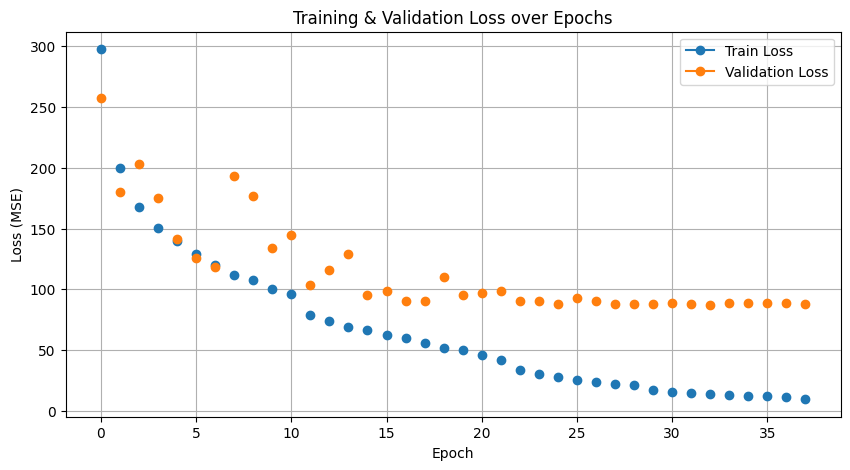

In [ ]:
# Paplottinti train/val loss
df = pd.read_csv("logs/resnet_age_estimation/version_0/metrics.csv")
df = df[df["epoch"].notna()]
plt.figure(figsize=(10,5))
if "train_loss_epoch" in df.columns:
    plt.plot(df["epoch"], df["train_loss_epoch"], label="Train Loss", marker='o')
if "val_loss" in df.columns:
    plt.plot(df["epoch"], df["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


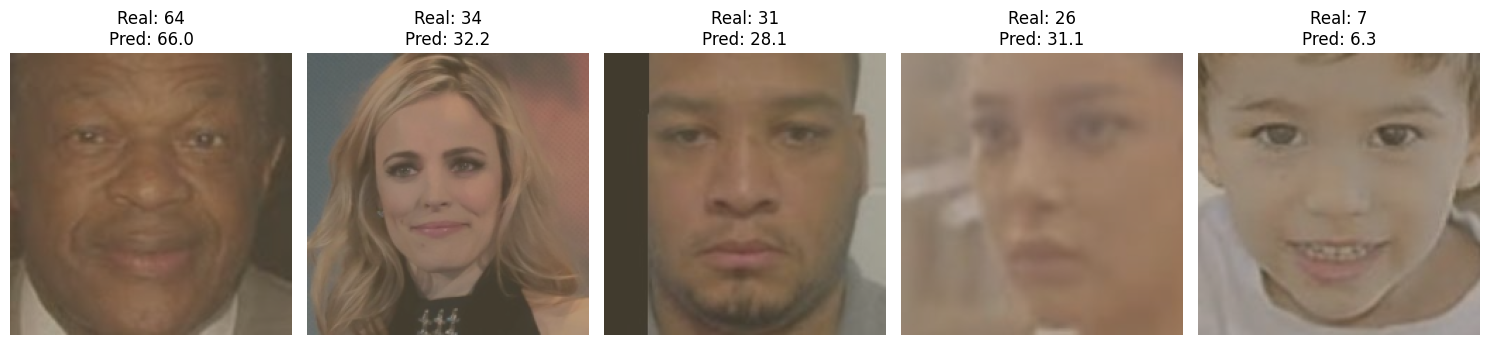

In [ ]:
# Plottingas random nuotrauku is testo (Real/pred age)
model = LitRN50.load_from_checkpoint("final_resnet50_model.ckpt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
test_ds = data.test_ds
N = 5
plt.figure(figsize=(15, 6))
for i in range(N):
    idx = random.randint(0, len(test_ds) - 1)
    img, true_age = test_ds[idx]
    img_batch = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_age = model(img_batch).item()
    img_np = img.permute(1, 2, 0).cpu().numpy()
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img_np = img_np * std + mean
    img_np = img_np.clip(0, 1)
    plt.subplot(1, N, i + 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Real: {int(true_age)}\nPred: {pred_age:.1f}")
plt.tight_layout()
plt.show()
